<a href="https://colab.research.google.com/github/Kyveli-tsioli/hello-world/blob/main/Autoencoders_assignement_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.1.0)


In [2]:
import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import random
from google.colab import files


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy


In [5]:
##################################
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
train_images
print(np.shape(train_images))
print(np.shape(test_images))

(60000, 28, 28)
(10000, 28, 28)


In [7]:
#create train set, validation set, test set
train_set=train_images[0:50000,:,:]
print("train set",np.shape(train_set))
valid_set=train_images[50000:60000,:,:]
print("validation set",np.shape(valid_set))
test_set=test_images
print("test set",np.shape(test_images))



train set (50000, 28, 28)
validation set (10000, 28, 28)
test set (10000, 28, 28)


In [8]:
type(train_set)
print(type(valid_set))
print(type(test_set))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
#label sets
train_set_labels=train_labels[0:50000]
print("train set labels",np.shape(train_set_labels))
valid_set_labels=train_labels[50000:60000]
print("validation set labels",np.shape(valid_set_labels))
test_set_labels=test_labels
print("test set labels",np.shape(test_set_labels))

train set labels (50000,)
validation set labels (10000,)
test set labels (10000,)


In [10]:
train_set[0,:,:]
np.shape(train_set[0,:,:])

(28, 28)

In [11]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
#train_dataset, test_dataset = dataset['train'], dataset['test']

In [12]:
class_names = metadata.features['label'].names
#not included with the dataset, store them here to use later when plotting images 


print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [13]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

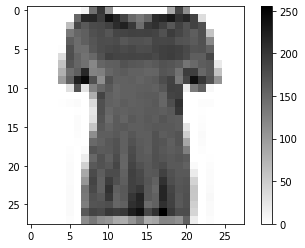

In [14]:
plt.figure()
plt.imshow(train_set[10],cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [15]:
#preprocessing-normalisation

train_set=train_set/255.0
valid_set=valid_set/255.0
test_set=test_set/255.0

#scale these values to a range of 0 to 1 before feeding them to the neural network 
#divide the values by 255




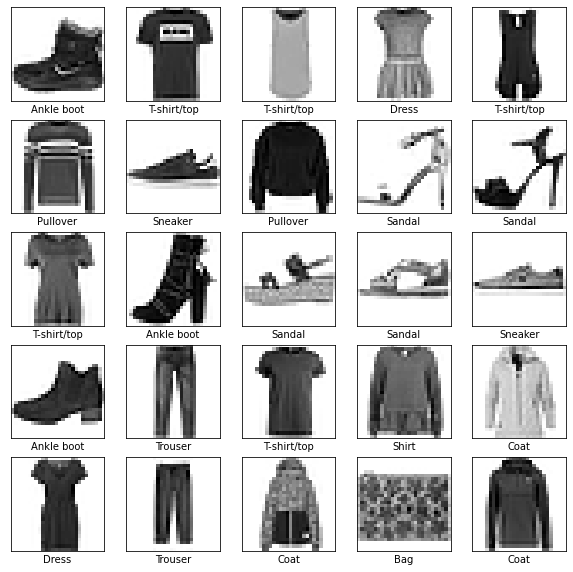

In [16]:
#display the first 25 images from the training set
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_set[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[train_set_labels[i]])
plt.show()

In [17]:
np.shape(train_set)

(50000, 28, 28)

In [18]:
np.shape(valid_set)

(10000, 28, 28)

In [19]:
#Construct the function noise which removes one or two quadrants of the image
def noise(x):
  corrupted_images=[]
  for i in range(np.shape(x)[0]):
    x_copy=np.copy(x[i])
    x_offset=random.randint(1,14)
    y_offset=random.randint(1,14)
    for k in range(x_offset,x_offset+14):
        for m in range(y_offset,y_offset+14):
            x_copy[k,m]=0
    corrupted_images.append(x_copy)
    
  return np.array(corrupted_images)


In [20]:
#trial: we apply the noise function only for a subset of images 
train_set=train_set[0:50000]
train_set_labels=train_set_labels[0:50000]
valid_set=train_set[0:200]
valid_set_labels=valid_set_labels[0:200]


In [21]:
#take the noise version of each and every picture in the training set
train_set_corr=noise(train_set)
valid_set_corr=noise(valid_set)
test_set_corr=noise(test_set)
print(test_set_corr.shape)
print(type(test_set_corr))

(10000, 28, 28)
<class 'numpy.ndarray'>


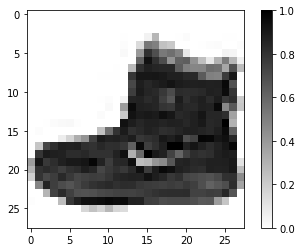

In [22]:
plt.figure()
plt.imshow(train_set[0],cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()




In [23]:
np.shape(train_set_corr)

(50000, 28, 28)

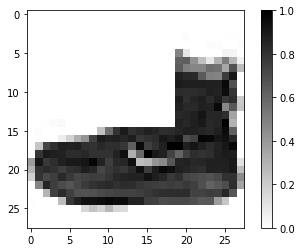

In [24]:
plt.figure()
plt.imshow(train_set_corr[0],cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

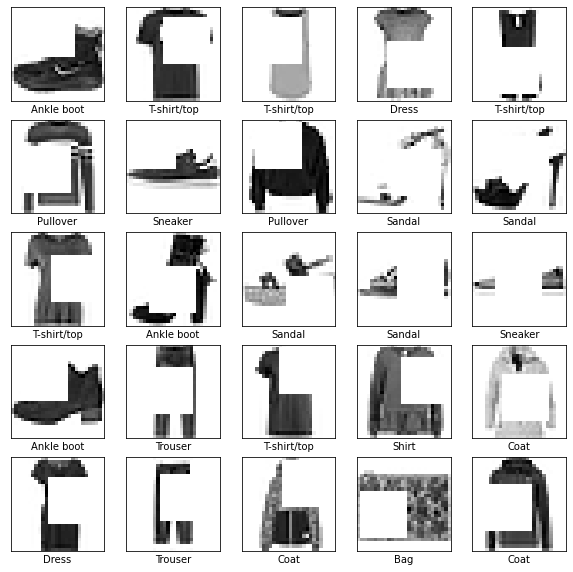

In [25]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_set_corr[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[train_set_labels[i]])
plt.show()

In [26]:
#convert data to torch tensors
#train_set_tensor=torch.tensor(train_set,dtype=torch.float)
#rain_labels_tensor=torch.tensor(train_labels,dtype=torch.float)
#valid_set_tensor=torch.tensor(valid_set,dtype=torch.float)
#valid_labels_tensor=torch.tensor(valid_set,dtype=torch.float)
#test_set_tensor=torch.tensor(test_set,dtype=torch.float)
#test_labels_tensor=torch.tensor(test_set,dtype=torch.float)

In [27]:
#make them 2D arrays
x_train=[]
for i in range(train_set.shape[0]):
  x_train.append(train_set[i].flatten())
x_train=np.array(x_train)
print(x_train)
print(np.shape(x_train))

x_valid=[]
for i in range(valid_set.shape[0]):
  x_valid.append(valid_set[i].flatten())
x_valid=np.array(x_valid)
print(x_valid)
print(np.shape(x_valid))

x_test=[]
for i in range(test_set.shape[0]):
  x_test.append(test_set[i].flatten())
x_test=np.array(x_test)
print(x_test)
print(np.shape(x_test))

x_train_corr=[]
for i in range(train_set_corr.shape[0]):
  x_train_corr.append(train_set_corr[i].flatten())
x_train_corr=np.array(x_train_corr)
print(x_train_corr)
print(np.shape(x_train_corr))


x_valid_corr=[]
for i in range(valid_set_corr.shape[0]):
  x_valid_corr.append(valid_set_corr[i].flatten())
x_valid_corr=np.array(x_valid_corr)
print(x_valid_corr)
print(np.shape(x_valid_corr))

x_test_corr=[]
for i in range(test_set_corr.shape[0]):
  x_test_corr.append(test_set_corr[i].flatten())
x_test_corr=np.array(x_test_corr)
print(x_test_corr)
print(np.shape(x_test_corr))



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(50000, 784)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.08235294 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(200, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(50000, 784)
[[0.         0.         0.         ...

In [28]:
#convert data to torch tensors
#train set tensors
train_set_tensor=torch.tensor(x_train,dtype=torch.float)
train_labels_tensor=torch.tensor(train_set_labels,dtype=torch.float)


#validation set tensors
valid_set_tensor=torch.tensor(x_valid,dtype=torch.float)
valid_labels_tensor=torch.tensor(valid_set_labels,dtype=torch.float)

#test set tensors
test_set_tensor=torch.tensor(x_test,dtype=torch.float)
test_labels_tensor=torch.tensor(test_set_labels,dtype=torch.float)

#corrupted tensors for the 3 sets
train_set_corr_tensor=torch.tensor(x_train_corr,dtype=torch.float)
valid_set_corr_tensor=torch.tensor(x_valid_corr,dtype=torch.float)
test_set_corr_tensor=torch.tensor(x_test_corr,dtype=torch.float)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  after removing the cwd from sys.path.


In [29]:
print(train_set_tensor.size())
print("train set tensor size:",train_set_tensor.shape)
print("valid set tensor size:",valid_set_tensor.shape)
print("test set tensor size:",test_set_tensor.shape)
print("corrupted train",train_set_corr_tensor.shape)
print("corrupted valid",valid_set_corr_tensor.shape)
print("corrupted test", test_set_corr_tensor.shape)

torch.Size([50000, 784])
train set tensor size: torch.Size([50000, 784])
valid set tensor size: torch.Size([200, 784])
test set tensor size: torch.Size([10000, 784])
corrupted train torch.Size([50000, 784])
corrupted valid torch.Size([200, 784])
corrupted test torch.Size([10000, 784])


In [30]:
#use the training set tesdor and the train labels tensor to create a TensorDataset as well
#as a DataLoader that allows to load batches of our data during each training iteration

batch_size=100
trainset=torch.utils.data.TensorDataset(train_set_tensor,train_set_corr_tensor) #train_set_corr
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2)


#same for validation set
validset=torch.utils.data.TensorDataset(valid_set_tensor,valid_set_corr_tensor) #corrupted
validloader=torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False,num_workers=2)


#provides an unterator that takes in a dataset object and performs batching, shuffling and loading of the data
#this is crucial when images are big in size and take time to load
#dataloader class using multiprocessing fetches the data asychronously and prefetches batches to be sent to the GPU
#dataloader can load multiple samples parallelly using torch.multiprocessing workers
#training set was wrapped or loaded into the dataloader giving us acces to the 
#underlying data in desired format
#quering capabilities, we can shuffle, batch size for the training stage
#dataloader: we use the constructor and pass the trainset 


In [31]:
###see the trainloader thing

#dataiter=iter(trainloader)
#images,labels=dataiter.next()
#print("labels shape",labels.shape)
#print("train set corr tensor shape",train_set_corr_tensor.shape)
#print(images.shape)
#print(images[0]==train_set_tensor[0])
#print(labels[0]==train_set_corr_tensor[0])
#print(images[0])
#print(labels[0])

In [32]:
#sample=next(iter(train_set_tensor))
#print(sample)
#print("",len(sample))


#sample: to access an individual element of the train_set_tensor we pass
#the object to python's builtin iter function
#which returns an object representing a stream of data that then we can iterate over
#with that stream of data we can use python's builtin next function
#to get the next data element in the stream
#we expect a single sample: thats why we named it 'sample'
#len(sample)
#length is 2 because the dataaset containes image label pairs, 
#each sample we retrieve from the training dataset contains
#image data as tensor and the corresponding label as a tensor

#image,label=sample #image unpacking
#accessing each item in the sequence using its index
#sequence unpacking to assign the image and the label 
#this is equivalent to: image=sample[0], label=sample[1]
#deconstructing object
#print(sample)
#type(sample)
#image.shape



In [33]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()

    #encoder
    self.input_size=28*28   #to be defined outside the class according to the size of the set 
    self.enc1=nn.Linear(self.input_size,256)
    self.enc2=nn.Linear(256,128) 
    self.enc3=nn.Linear(128,64)
    self.enc4=nn.Linear(64,32)
    self.enc5=nn.Linear(32,16)
 


    #decoder
    self.dec1=nn.Linear(16,32)
    self.dec2=nn.Linear(32,64)
    self.dec3=nn.Linear(64,128)
    self.dec4=nn.Linear(128,256)
    self.dec5=nn.Linear(256,self.input_size)


  def forward(self,x):
    x = torch.relu(self.enc1(x))
    x = torch.relu(self.enc2(x))
    x = torch.relu(self.enc3(x))
    x = torch.relu(self.enc4(x))
    x = torch.relu(self.enc5(x))

    x = torch.relu(self.dec1(x))
    x = torch.relu(self.dec2(x))
    x = torch.relu(self.dec3(x))
    x = torch.relu(self.dec4(x))
    x = torch.relu(self.dec5(x))
    return x



In [34]:
#create an instance of the autoencoder class 
model=autoencoder()
print(model)

autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [35]:
criterion=nn.MSELoss()
learning_rate=0.0001
epochs=5
#optimizer=optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [36]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [37]:
#new entries for the grid search
#layer_sizes=[[28**2,]
#layer_depths=[2,3,4,5,6]
#batch_size_list=[100,150,200] #validation set 200
#learning_rate_list=[0.0001,0.001,0.01,0.1]
#activations=[torch.sigmoid,torch.relu]
#activation_names=['sigmoid','relu']


In [38]:
#training 
def training(model,train_loader,valid_loader,epochs):
  
  
  loss_epochs=[]
  valid_loss_epochs=[]
  epoch_list=[]
  test_loss_epochs=[]

  for epoch in range(epochs):  # loop over the dataset multiple times
    
    num_of_batches=0
    epoch_list.append(epoch)
    batch_loss=[]

    
    for i,data in enumerate (train_loader,0): #batch in trainloader, for each of the epochs we split the training data into mini batches using the DataLoader 
        
        img_real, img_corr = data #get batch #img stands for the corrupted images while labels stands for the real images 
        
        optimizer.zero_grad()  #clear the gradients at each batch step, in pytorch we need to set the gradients to zero before starting to do backpropagation because it accummulates the gradients on subsequent backward passes 
       
        output=model(img_corr)  #forward pass: passs batch, compute predicted outputs  
        
        
        loss=criterion(output,img_real)
        
        loss.backward()   #backward pass: compute gradient of loss with respect to model parameters 
        optimizer.step()  #update weights, performs a parameter update based on the current gradient, otherwise backward wouldnt update the weights without the optimizer, it would just compute gradients  
          
        batch_loss.append(loss.item()) 
        #batch_loss.append(loss.item()*batch_size) 
        num_of_batches=+1
 
    
    loss_epochs.append(np.mean(np.array(batch_loss))) #The average of the batch losses will give you an estimate of the “epoch loss” during training

   
    #validation set metrics
    valid_img_real,valid_img_corr=valid_set_tensor,valid_set_corr_tensor
    output_valid=model(valid_img_corr)
    valid_loss=criterion(output_valid,valid_img_real)
    valid_loss_epochs.append(valid_loss.item())
    #valid_loss_epochs.append(valid_loss.item()*batch_size)

    #test set metrics: needed for the last question
    test_img_real,test_img_corr=test_set_tensor,test_set_corr_tensor
    output_test=model(test_img_corr)
    test_loss=criterion(output_test,test_img_real)
    test_loss_epochs.append(test_loss.item())


    #validation loss and training loss over the epochs
    print(epoch," validation loss",valid_loss_epochs[-1],"training loss ",loss_epochs[-1])

    
    
  training_loss_plot=plt.plot(epoch_list,loss_epochs,label='Training loss')
  validation_loss_plot=plt.plot(epoch_list,valid_loss_epochs,label='Validation loss')
  plt.legend()
  plt.title("Loss per epochs")
  plt.show()
  
  #trial#
  #reshaped_valid_output = output_valid.reshape(200, 28, 28)




  #final question: provide a set of 32 images in their original, noisy and decoded form from the test set
  for i in range(32):
    index = random.randrange(0, 10000)
    print("index of the image", index)
    #real test set image
    print("original image from the test set")
    reshaped_test_real=test_img_real.view(10000,28,28) 
    reshaped_test_real=reshaped_test_real.cpu().detach().numpy() #use detach when its an output that requires grad
    plt.figure()
    plt.imshow(reshaped_test_real[index,:,:])
    plt.show()
    plt.savefig("original_image_test_set.png")
    #files.download("original_image_test_set.png")   



    #noisy test set image
    print("corrupted image from the test set")
    reshaped_test_corr=test_img_corr.view(10000,28,28) #validation set corrupted image
    reshaped_test_corr=reshaped_test_corr.cpu().detach().numpy() #use detach when its an output that requires grad
    plt.figure()
    plt.imshow(reshaped_test_corr[index,:,:])
    plt.show()
    plt.savefig("corrupted_image_test_set.png")
    #files.download("corrupted_image_test_set.png")



    #denoised test set image
    print("denoised image from the test set")
    reshaped_test_output=output_test.view(10000,28,28) #validation set corrupted image
    reshaped_test_output=reshaped_test_output.cpu().detach().numpy() #use detach when its an output that requires grad
    plt.figure()
    plt.imshow(reshaped_test_output[index,:,:])
    plt.show()
    plt.savefig("denoised_image_test_set.png")
    #files.download("denoised_image_test_set.png")


  #image,label=sample accessing each item in a sequence using an index
  #sequence unpacking


0  validation loss 0.09159433841705322 training loss  0.11710719010233879
1  validation loss 0.06469392776489258 training loss  0.07264807710796595
2  validation loss 0.06025790423154831 training loss  0.061412655279040336
3  validation loss 0.056465279310941696 training loss  0.057920536026358604
4  validation loss 0.05370822921395302 training loss  0.05515545458346605


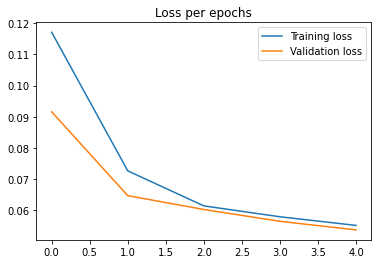

index of the image 7725
original image from the test set


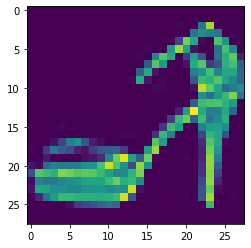

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

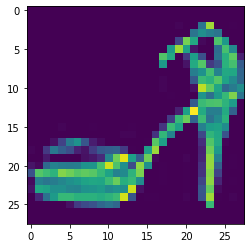

denoised image from the test set


<Figure size 432x288 with 0 Axes>

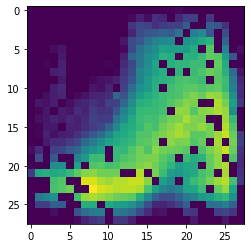

index of the image 3465
original image from the test set


<Figure size 432x288 with 0 Axes>

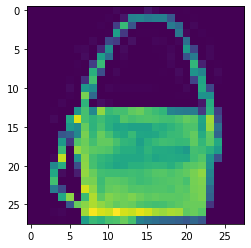

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

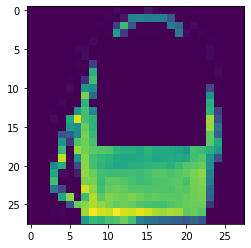

denoised image from the test set


<Figure size 432x288 with 0 Axes>

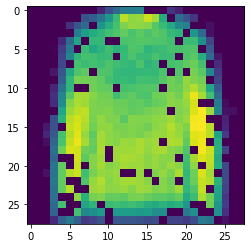

index of the image 6776
original image from the test set


<Figure size 432x288 with 0 Axes>

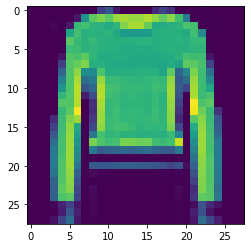

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

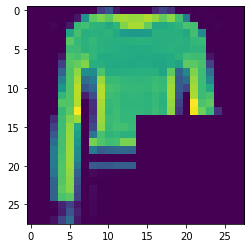

denoised image from the test set


<Figure size 432x288 with 0 Axes>

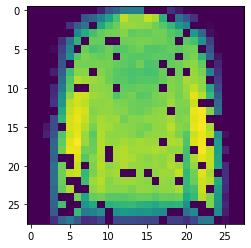

index of the image 1132
original image from the test set


<Figure size 432x288 with 0 Axes>

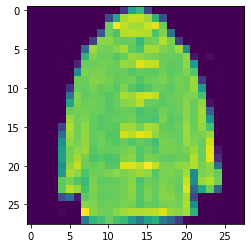

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

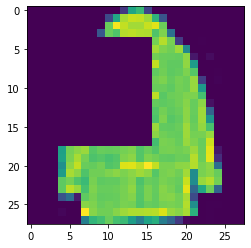

denoised image from the test set


<Figure size 432x288 with 0 Axes>

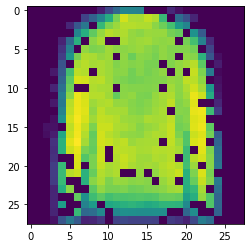

index of the image 3468
original image from the test set


<Figure size 432x288 with 0 Axes>

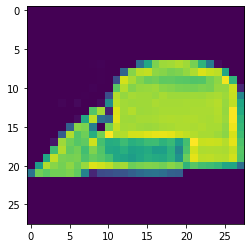

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

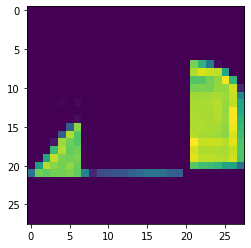

denoised image from the test set


<Figure size 432x288 with 0 Axes>

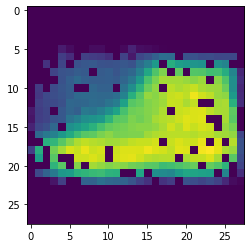

index of the image 299
original image from the test set


<Figure size 432x288 with 0 Axes>

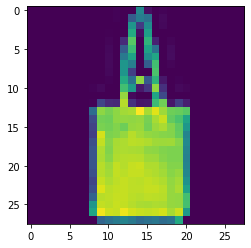

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

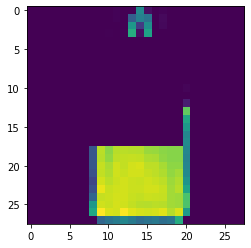

denoised image from the test set


<Figure size 432x288 with 0 Axes>

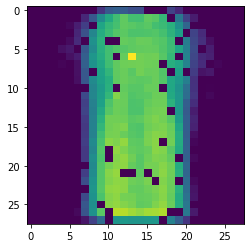

index of the image 5138
original image from the test set


<Figure size 432x288 with 0 Axes>

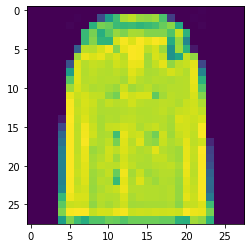

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

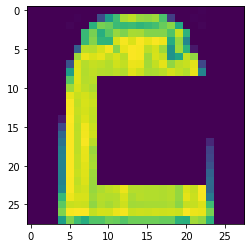

denoised image from the test set


<Figure size 432x288 with 0 Axes>

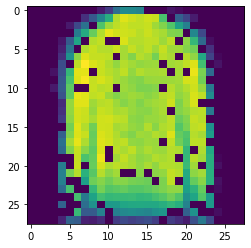

index of the image 8967
original image from the test set


<Figure size 432x288 with 0 Axes>

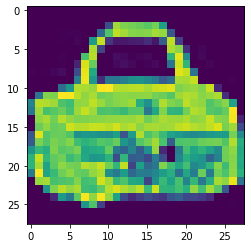

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

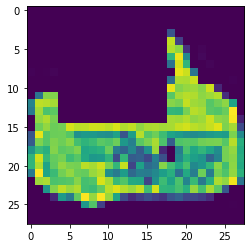

denoised image from the test set


<Figure size 432x288 with 0 Axes>

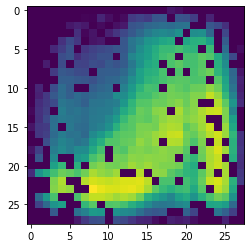

index of the image 8152
original image from the test set


<Figure size 432x288 with 0 Axes>

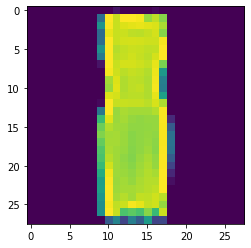

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

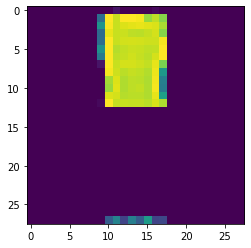

denoised image from the test set


<Figure size 432x288 with 0 Axes>

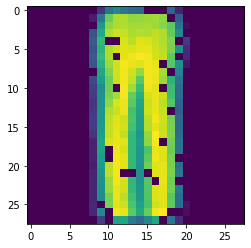

index of the image 2136
original image from the test set


<Figure size 432x288 with 0 Axes>

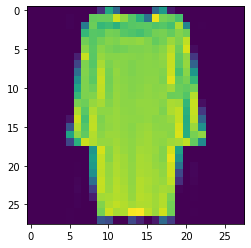

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

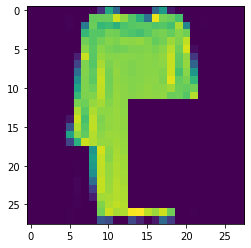

denoised image from the test set


<Figure size 432x288 with 0 Axes>

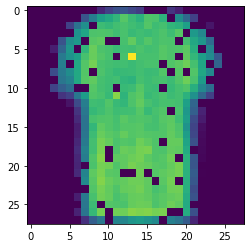

index of the image 4824
original image from the test set


<Figure size 432x288 with 0 Axes>

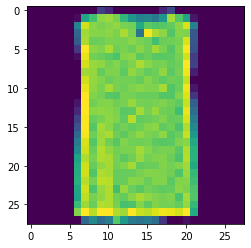

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

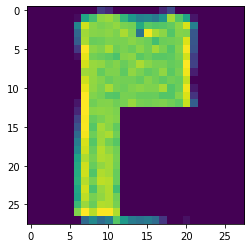

denoised image from the test set


<Figure size 432x288 with 0 Axes>

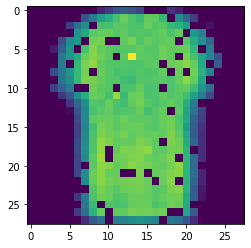

index of the image 40
original image from the test set


<Figure size 432x288 with 0 Axes>

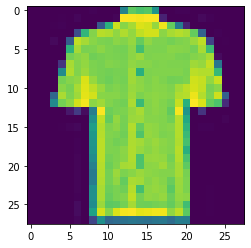

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

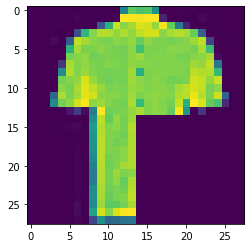

denoised image from the test set


<Figure size 432x288 with 0 Axes>

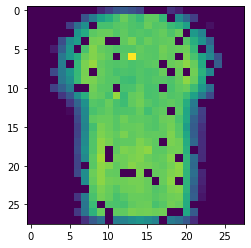

index of the image 9609
original image from the test set


<Figure size 432x288 with 0 Axes>

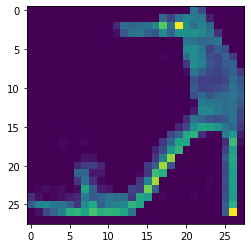

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

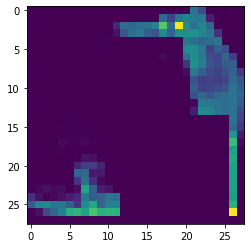

denoised image from the test set


<Figure size 432x288 with 0 Axes>

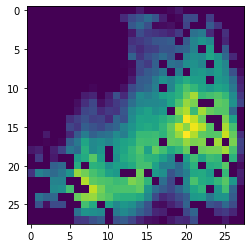

index of the image 5401
original image from the test set


<Figure size 432x288 with 0 Axes>

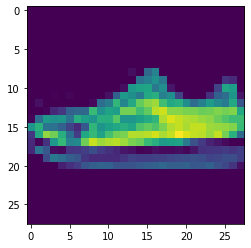

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

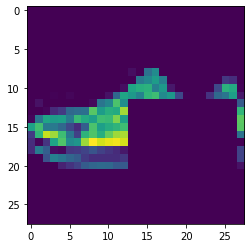

denoised image from the test set


<Figure size 432x288 with 0 Axes>

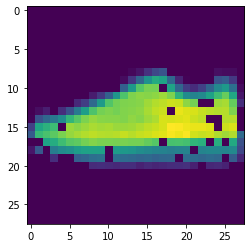

index of the image 9284
original image from the test set


<Figure size 432x288 with 0 Axes>

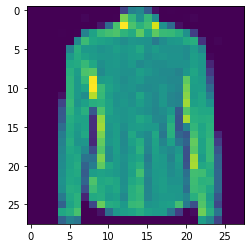

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

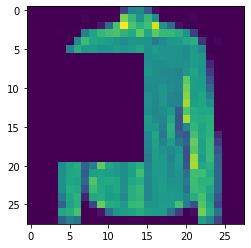

denoised image from the test set


<Figure size 432x288 with 0 Axes>

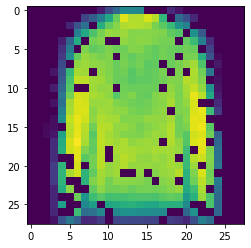

index of the image 3136
original image from the test set


<Figure size 432x288 with 0 Axes>

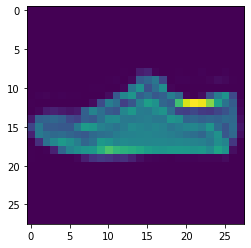

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

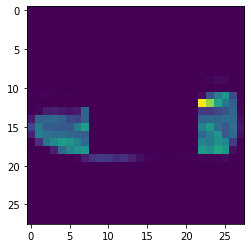

denoised image from the test set


<Figure size 432x288 with 0 Axes>

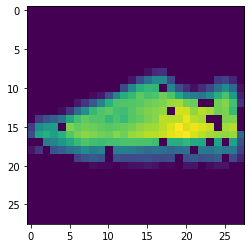

index of the image 755
original image from the test set


<Figure size 432x288 with 0 Axes>

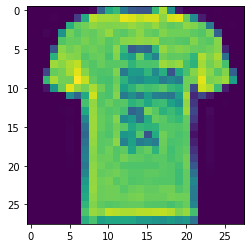

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

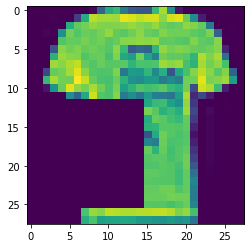

denoised image from the test set


<Figure size 432x288 with 0 Axes>

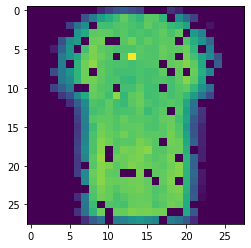

index of the image 1848
original image from the test set


<Figure size 432x288 with 0 Axes>

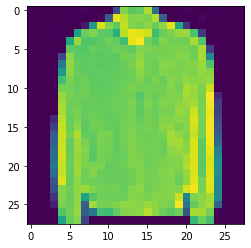

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

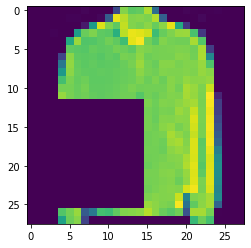

denoised image from the test set


<Figure size 432x288 with 0 Axes>

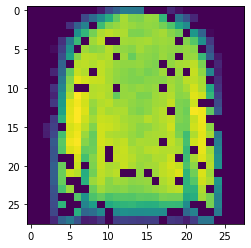

index of the image 6094
original image from the test set


<Figure size 432x288 with 0 Axes>

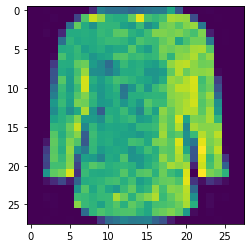

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

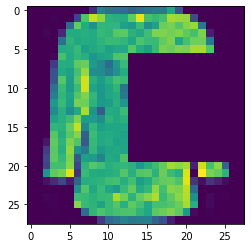

denoised image from the test set


<Figure size 432x288 with 0 Axes>

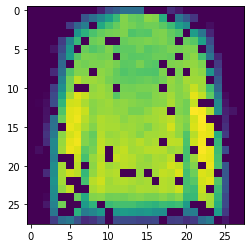

index of the image 2933
original image from the test set


<Figure size 432x288 with 0 Axes>

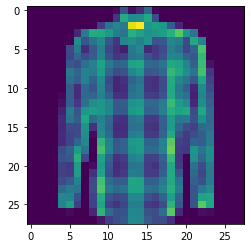

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

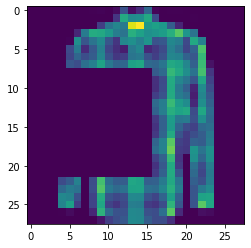

denoised image from the test set


<Figure size 432x288 with 0 Axes>

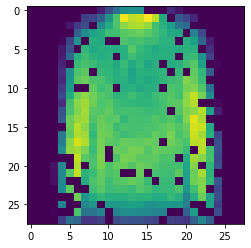

index of the image 6892
original image from the test set


<Figure size 432x288 with 0 Axes>

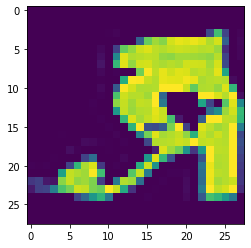

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

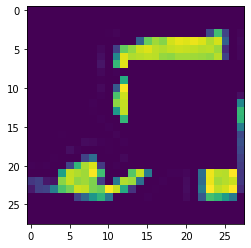

denoised image from the test set


<Figure size 432x288 with 0 Axes>

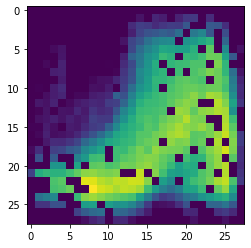

index of the image 5902
original image from the test set


<Figure size 432x288 with 0 Axes>

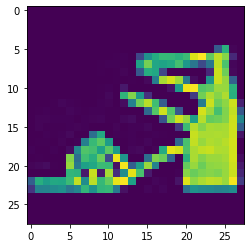

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

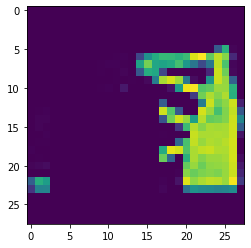

denoised image from the test set


<Figure size 432x288 with 0 Axes>

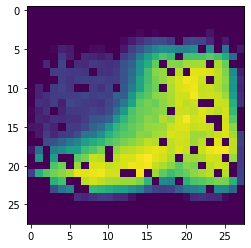

index of the image 610
original image from the test set


<Figure size 432x288 with 0 Axes>

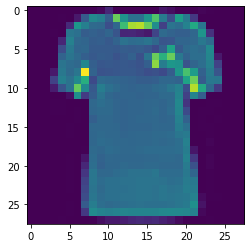

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

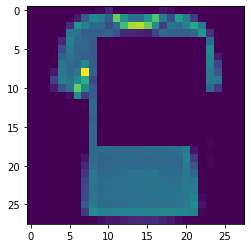

denoised image from the test set


<Figure size 432x288 with 0 Axes>

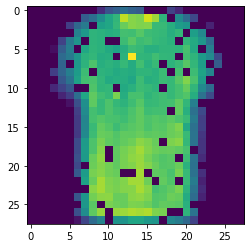

index of the image 1328
original image from the test set


<Figure size 432x288 with 0 Axes>

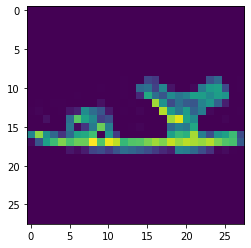

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

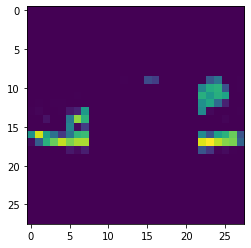

denoised image from the test set


<Figure size 432x288 with 0 Axes>

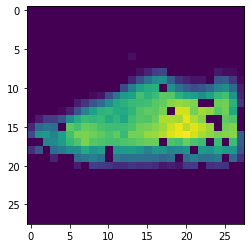

index of the image 2598
original image from the test set


<Figure size 432x288 with 0 Axes>

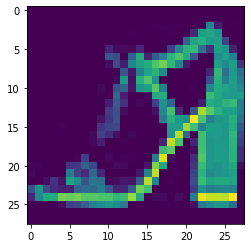

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

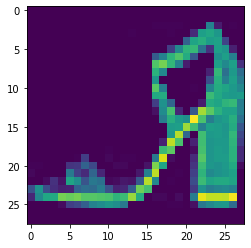

denoised image from the test set


<Figure size 432x288 with 0 Axes>

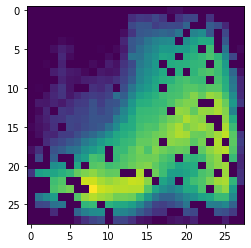

index of the image 7575
original image from the test set


<Figure size 432x288 with 0 Axes>

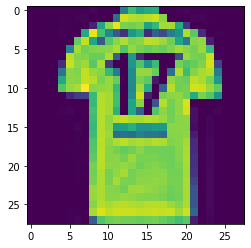

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

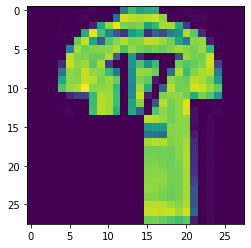

denoised image from the test set


<Figure size 432x288 with 0 Axes>

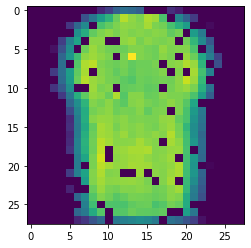

index of the image 4781
original image from the test set


<Figure size 432x288 with 0 Axes>

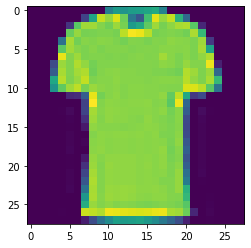

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

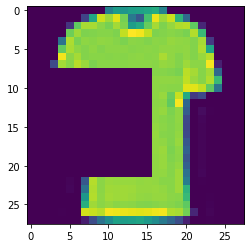

denoised image from the test set


<Figure size 432x288 with 0 Axes>

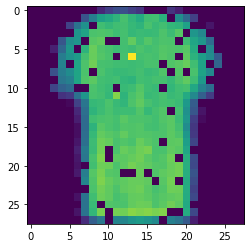

index of the image 2921
original image from the test set


<Figure size 432x288 with 0 Axes>

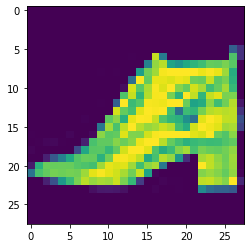

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

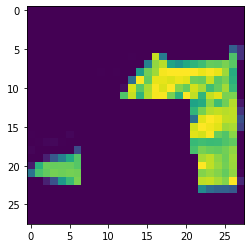

denoised image from the test set


<Figure size 432x288 with 0 Axes>

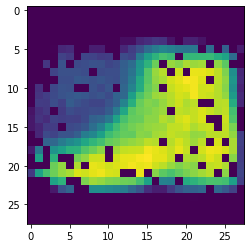

index of the image 7131
original image from the test set


<Figure size 432x288 with 0 Axes>

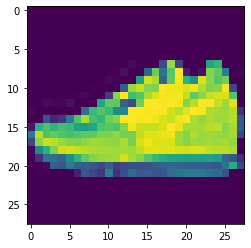

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

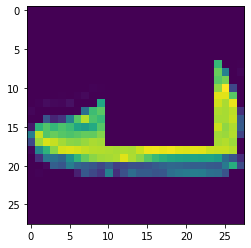

denoised image from the test set


<Figure size 432x288 with 0 Axes>

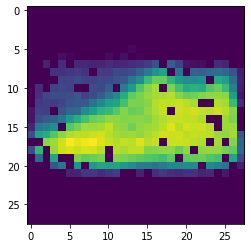

index of the image 869
original image from the test set


<Figure size 432x288 with 0 Axes>

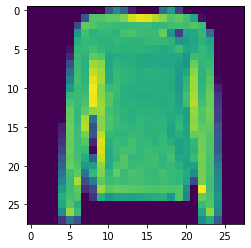

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

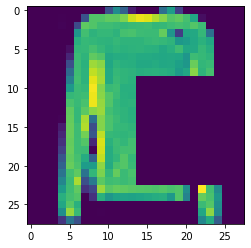

denoised image from the test set


<Figure size 432x288 with 0 Axes>

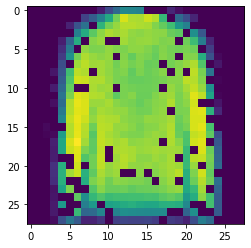

index of the image 3734
original image from the test set


<Figure size 432x288 with 0 Axes>

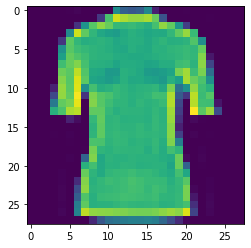

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

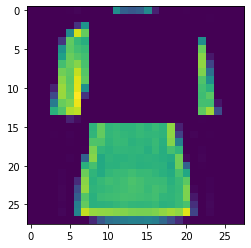

denoised image from the test set


<Figure size 432x288 with 0 Axes>

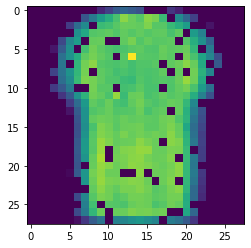

index of the image 8193
original image from the test set


<Figure size 432x288 with 0 Axes>

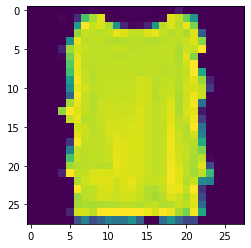

corrupted image from the test set


<Figure size 432x288 with 0 Axes>

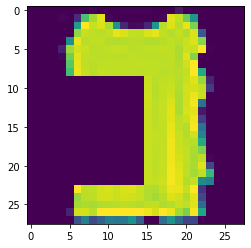

denoised image from the test set


<Figure size 432x288 with 0 Axes>

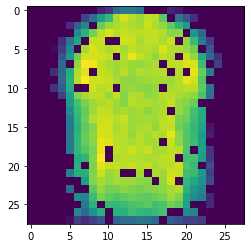

<Figure size 432x288 with 0 Axes>

In [39]:
trial1=training(model,trainloader,validloader,epochs)


In [40]:
#code that works, plot images from the validation set


#for i in range(5):
    #predicted by the network validation set image 
    #print("predicted by the network image from the validation set")
    #reshaped_valid_output = output_valid.reshape(200, 28, 28)
    #reshaped_valid_output = reshapedvalid_output.detach().numpy()
    #plt.imshow(reshaped_valid_output[i, :, :])
    #plt.figure()
    #plt.show()



    #real validation set image
    #print("real image from the validation set")
    #reshaped_valid_real=valid_img_real.view(200,28,28) 
    #reshaped_valid_real=reshaped_valid_real.cpu().detach().numpy() #use detach when its an output that requires grad
    #plt.figure()
    #plt.imshow(reshaped_valid_real[i,:,:])
    #plt.show()


    #disruppted validation set image
    #print("corrupted image from the validation set")
    #reshaped_valid_corr=valid_img_corr.view(200,28,28)
    #reshaped_valid_corr=reshaped_valid_corr.cpu().detach().numpy() #use detach when its an output that requires grad
    #plt.figure()
    #plt.imshow(reshaped_valid_corr[i,:,:])
    #plt.show()

In [41]:
#comments
#impose a bottleneck in the network which forces a compressed knowledge representation
#of the original input
#if the input features were each independent of one another, this compression and subsequent
#reconstruction would be very difficult task
#however if some sort of structure exists in the data (i.e correlations between input features)
#this structure can be learned
#a bottleneck constraints the amount of information that can traverse the full network
#forcing a learned compression of the input data
#getting your model to actually learn a meaningful and generilizable latent space representation
#


In [42]:
#hyperparameter search: grid search

def tuning():
  layer_sizes=[[28**2,]
  layer_depths=[2,3,4,5,6]
  batch_sizes=[100,150,200] #validation set 200
  learning_rates=[0.0001,0.001,0.01,0.1]
  activations=[torch.sigmoid,torch.relu]
  activation_names=['sigmoid','relu']


  #array to hold instances of autoncoder class for each hyperparameter combination
  trained_autoencoders=np.empty_like(np.zeroes((len(layer_sizes))))

SyntaxError: ignored